In [3]:
import numpy as np
import pandas as pd
import random
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from epitools import between_p, within_p

In this notebook, we propose an algoritmic implementation for calculating the antagonism of candidate $i$ by using different definitions of polarization.

In [4]:
def gini_coefficient(x):
    """Compute Gini coefficient of array of values"""
    diffsum = 0
    for i, xi in enumerate(x[:-1], 1):
        diffsum += np.sum(np.abs(xi - x[i:]))
    return diffsum / (len(x)**2 * np.mean(x))

In [5]:
gini_coefficient(np.array([0, 1, 2, 5, 1111]))

0.7957104557640751

In [6]:
df = pd.DataFrame([
    ("A", 33),
    ("B", 33),
    # ("C", 33),
], columns=["candidate", "value"])
df["rate"] = df["value"] / df["value"].sum()
df

,candidate,value,rate
0,A,33,0.5
1,B,33,0.5


In [7]:
def er_polarization(
        input_df, 
        alpha=0
    ):
    """Esteban and Ray Polarization (1994)
    """

    weights = input_df["value"].values
    rates = input_df["rate"].values
    K = 1 / (weights.sum() ** (2 + alpha))

    xx = np.multiply.outer(weights ** (1 + alpha), weights)
    yy = np.absolute(np.subtract.outer(rates, rates))
    # avg = np.average(rates, weights=weights)

    return K * np.sum(xx * yy)

#### Esteban-Ray (1994)
$ER_{i} = K \sum\limits_{k=1}^{M} \sum\limits_{j=1}^{N} v_{i,k}^{1+\alpha}v_{j,k}|r_{i,k}-r_{j,k}|$

In [8]:
def esteban_ray(
    input_df,
    alpha=0
):
    value = 0
    population = np.sum(input_df["value"])
    K = 1 / (population ** (2 + alpha))

    for i, xx in input_df.iterrows():
        for j, yy in input_df.iterrows():
            alienation = np.absolute(xx.rate - yy.rate)
            identification = xx.value ** (1 + alpha) * yy.value
            value += alienation * identification

    return K * value


#### Wang-Tsui (1998)

$WT_{i}=\frac{K}{P}\sum\limits_{k=1}^{M}v_{i,k}\left|\frac{r_{i,k}-m_i}{m_i}\right|^\gamma$

In [9]:
def tsui_wang(
    input_df,
    K:int = 1,
    gamma:float = 0.5
):
    median = np.median(input_df["rate"])
    population = np.sum(input_df["value"])

    value = 0
    for i, xx in input_df.iterrows():
        value += xx.value * np.absolute((xx.rate - median)/median) ** gamma
        
    return K * value / population

tsui_wang(df)

0.0

#### Reynal-Querol

$RQ_{i} = 1 - \sum\limits_{k=1}^{M}\left(\frac{1/2 - r_{i,k}}{1/2}\right)^2r_{i,k}$

In [58]:
def reynal_querol(
    input_df
):
    return 1 - (input_df["rate"].apply(lambda x:(((0.5 - x)/0.5)**2 * x))).sum()

reynal_querol(df)

-72769.65639999999

In [57]:
1 - (((0.5 - 0.99)/0.5)**2*0.99 + ((0.5 - 0.01)/0.5)**2*0.01)

0.03960000000000019

#### Dispersion (Standard Deviation)

$\text{Dispersion}_{i} = \sqrt{\frac{\sum\limits_{k=1}^{M}\left(r_{i,k}-\mu_i\right)^2}{M-1}}$

Where $M$ is the number of units, $r_{i}$ the percent of votes of $i$ in $k$, and $\mu_i$ is the voting percentage of $i$ in the election.

In [11]:
def dispersion(
    input_df
):
    return np.std(input_df["rate"])

In [12]:
def weighted_dispersion(
    input_df,
    total=1
):
    weights = input_df["value"]
    vals = input_df["rate"]
    weighted_avg = weights.sum() / total #np.average(vals, weights=weights)

    numer = np.sum(weights * (vals - weighted_avg)**2)
    denom = ((vals.count()-1) / vals.count()) * np.sum(weights)

    return np.sqrt(numer / denom)

In [13]:
candidates = list("abcdefghijklmnopqrstuvw")[0:2]

output = []
polling_id = 1
for loop in range(3):
    for candidate_a in candidates:
        for candidate_b in candidates:
            rate = 0 if candidate_a != candidate_b else 1
            # rate = 1/len(candidates)
            output.append({
                "candidate": candidate_b,
                "rate": rate,
                "polling_id": polling_id
            })
        polling_id += 1

df = pd.DataFrame(output)
df["value"] = df["rate"] * 100
df

,candidate,rate,polling_id,value
0,a,1,1,100
1,b,0,1,0
2,a,0,2,0
3,b,1,2,100
4,a,1,3,100
5,b,0,3,0
6,a,0,4,0
7,b,1,4,100
8,a,1,5,100
9,b,0,5,0


In [59]:
test[test["election_id"] == 398]

,election_id,candidate,value,rate
792,398,A,9900.0,0.99
793,398,B,100.0,0.01


In [60]:
test = df.groupby(["election_id", "candidate"]).agg({"value": "sum"})
test["rate"] = test.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
test = test.reset_index()

test.groupby("election_id").apply(reynal_querol).sort_values()

election_id
398     0.0396
1598    0.0396
1058    0.0396
1038    0.0396
98      0.0396
         ...  
1383    1.0000
1823    1.0000
1424    1.0000
283     1.0000
1983    1.0000
Length: 2000, dtype: float64

In [15]:
df.groupby("candidate").apply(lambda x: esteban_ray(x))

candidate
a    0.0
b    0.0
dtype: float64

In [16]:
df.groupby("candidate").apply(lambda x: tsui_wang(x))

candidate
a    1.0
b    1.0
dtype: float64

In [17]:
df.groupby("candidate").apply(dispersion)

candidate
a    0.5
b    0.5
dtype: float64

In [61]:
df.groupby("candidate").apply(reynal_querol)

candidate
A   -64248.211756
B    -8520.444644
dtype: float64

In [19]:
df.groupby("candidate").apply(lambda x: weighted_dispersion(x, df["value"].sum()))

candidate
a    0.547723
b    0.547723
dtype: float64

## Generates synthetic data
For each combination of $\mu$ and $\sigma$, we generated 100 elections

In [20]:
import random

output = []
epi = {}
idx = 1
for iteration in range(100):
    for mu in [0.5, 0.66, 0.75, 0.8333, 1]:
        for sigma in [0.0025, 0.05, 0.10, 0.25]:
        
            distribution = [random.gauss(mu=mu, sigma=sigma) for x in range(100)]

            df_a = pd.DataFrame(distribution, columns=["rate"])
            df_a["candidate"] = "A"
            df_a["polling_id"] = range(df_a.shape[0])
            df_a.loc[df_a["rate"] <= 0, "rate"] = 0
            df_a.loc[df_a["rate"] >= 1, "rate"] = 1

            df_a["rate3"] = df_a["rate"].copy()
            df_a["rate2"] = df_a["rate"].apply(lambda x: np.round(x, 2))
            df_a["rate"] = df_a["rate"].apply(lambda x: x - x%0.01)

            df_b = df_a.copy()
            df_b["candidate"] = "B"
            df_b["rate"] = 1 - df_b["rate"]

            df = pd.concat([df_a, df_b], ignore_index=True)
            df["election_id"] = idx + 1
            idx += 1
            df["value"] = df["rate"] * 100
            df["mu"] = mu
            df["sigma"] = sigma
            output.append(df)
            bw = between_p(df)["value"].sum()
            wt = within_p(df)["value"].sum()
            epi[idx + 1] = {
                "within": wt,
                "between": bw,
                "total": bw + wt
            }

df = pd.concat(output, ignore_index=True)
df.head()

,rate,candidate,polling_id,rate3,rate2,election_id,value,mu,sigma
0,0.49,A,0,0.499090,0.5,2,49.0,0.5,0.0025
1,0.50,A,1,0.502946,0.5,2,50.0,0.5,0.0025
2,0.50,A,2,0.501227,0.5,2,50.0,0.5,0.0025
3,0.49,A,3,0.498755,0.5,2,49.0,0.5,0.0025
4,0.50,A,4,0.502047,0.5,2,50.0,0.5,0.0025


In [63]:
df_ER = df.groupby(["election_id", "candidate"]).apply(lambda x: er_polarization(x, alpha=0.25)).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})

df_ER = pd.merge(df_ER, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_ER.head()

,election_id,value,mu,sigma
0,2,0.003117,0.50,0.0025
1,3,0.032459,0.50,0.0500
2,4,0.065130,0.50,0.1000
3,5,0.148738,0.50,0.2500
4,6,0.002942,0.66,0.0025


In [62]:
df_RQ = df.groupby(["election_id", "candidate"]).apply(lambda x: reynal_querol(x)).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})
df_RQ = pd.merge(df_RQ, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_RQ.head()

,election_id,value,mu,sigma
0,2,1.9776,0.50,0.0025
1,3,1.1724,0.50,0.0500
2,4,-1.3768,0.50,0.1000
3,5,-19.0332,0.50,0.2500
4,6,-7.4588,0.66,0.0025


In [64]:
test = df.groupby(["election_id", "candidate"]).agg({"value": "sum"})
test["rate"] = test.groupby(level=[0], group_keys=False).apply(lambda x: x/x.sum())
test = test.reset_index()
df_RQ = test.groupby("election_id").apply(reynal_querol).reset_index().rename(columns={0: "value"})
df_RQ = pd.merge(df_RQ, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_RQ.head()

,election_id,value,mu,sigma
0,2,0.999875,0.50,0.0025
1,3,0.999998,0.50,0.0500
2,4,0.999900,0.50,0.1000
3,5,0.994845,0.50,0.2500
4,6,0.905505,0.66,0.0025


In [23]:
df_ER2 = df.groupby(["election_id", "candidate"]).apply(lambda x: er_polarization(x, alpha=1)).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})
df_ER2 = pd.merge(df_ER2, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_ER2.head()

,election_id,value,mu,sigma
0,2,0.000099,0.50,0.0025
1,3,0.001033,0.50,0.0500
2,4,0.002113,0.50,0.1000
3,5,0.005458,0.50,0.2500
4,6,0.000093,0.66,0.0025


In [24]:
df_DP = df.groupby(["election_id", "candidate"]).apply(lambda x: dispersion(x)).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})
df_DP = pd.merge(df_DP, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")

df_DP.head()

,election_id,value,mu,sigma
0,2,0.009928,0.50,0.0025
1,3,0.090962,0.50,0.0500
2,4,0.183488,0.50,0.1000
3,5,0.452964,0.50,0.2500
4,6,0.009656,0.66,0.0025


In [25]:
df_BW = df.groupby(["election_id"]).apply(lambda x: between_p(x)).groupby(level=[0]).sum()\
    .reset_index().rename(columns={"value": "value"})
df_BW = pd.merge(df_BW, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")

df_BW.head()

C:\Users\cnava\AppData\Local\Temp\ipykernel_4544\1284686341.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_BW = df.groupby(["election_id"]).apply(lambda x: between_p(x)).groupby(level=[0]).sum()\


,election_id,value,weight,mu,sigma
0,2,0.988801,1.0,0.50,0.0025
1,3,0.925400,1.0,0.50,0.0500
2,4,0.849601,1.0,0.50,0.1000
3,5,0.627652,1.0,0.50,0.2500
4,6,0.692632,1.0,0.66,0.0025


In [26]:
df_WT = df.groupby(["election_id"]).apply(lambda x: within_p(x)).groupby(level=[0]).sum()\
    .reset_index().rename(columns={"value": "value"})
df_WT = pd.merge(df_WT, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")

df_WT.head()

C:\Users\cnava\AppData\Local\Temp\ipykernel_4544\439051757.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df_WT = df.groupby(["election_id"]).apply(lambda x: within_p(x)).groupby(level=[0]).sum()\


,election_id,value,weight,mu,sigma
0,2,0.009856,1.0,0.50,0.0025
1,3,0.074544,1.0,0.50,0.0500
2,4,0.150214,1.0,0.50,0.1000
3,5,0.371872,1.0,0.50,0.2500
4,6,0.009316,1.0,0.66,0.0025


In [27]:
df_TW = df.groupby(["election_id", "candidate"]).apply(lambda x: tsui_wang(x, gamma=0.5)).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})

df_TW = pd.merge(df_TW, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_TW.head()

,election_id,value,mu,sigma
0,2,0.124499,0.50,0.0025
1,3,0.485687,0.50,0.0500
2,4,0.705860,0.50,0.1000
3,5,1.130551,0.50,0.2500
4,6,0.107739,0.66,0.0025


In [28]:
df_TW2 = df.groupby(["election_id", "candidate"]).apply(lambda x: tsui_wang(x, gamma=0.75)).groupby(level=[0]).sum()\
    .reset_index().rename(columns={0: "value"})

df_TW2 = pd.merge(df_TW2, df[["election_id", "mu", "sigma"]].drop_duplicates(), on="election_id")
df_TW2.head()

,election_id,value,mu,sigma
0,2,0.046827,0.50,0.0025
1,3,0.264635,0.50,0.0500
2,4,0.454989,0.50,0.1000
3,5,0.905675,0.50,0.2500
4,6,0.041564,0.66,0.0025


In [29]:
df_EP = pd.merge(df_BW, df_WT, on=["election_id", "mu", "sigma"])
df_EP["value"] = df_EP["value_x"] + df_EP["value_y"]
df_EP.head()

,election_id,value_x,weight_x,mu,sigma,value_y,weight_y,value
0,2,0.988801,1.0,0.50,0.0025,0.009856,1.0,0.998657
1,3,0.925400,1.0,0.50,0.0500,0.074544,1.0,0.999944
2,4,0.849601,1.0,0.50,0.1000,0.150214,1.0,0.999815
3,5,0.627652,1.0,0.50,0.2500,0.371872,1.0,0.999524
4,6,0.692632,1.0,0.66,0.0025,0.009316,1.0,0.701947


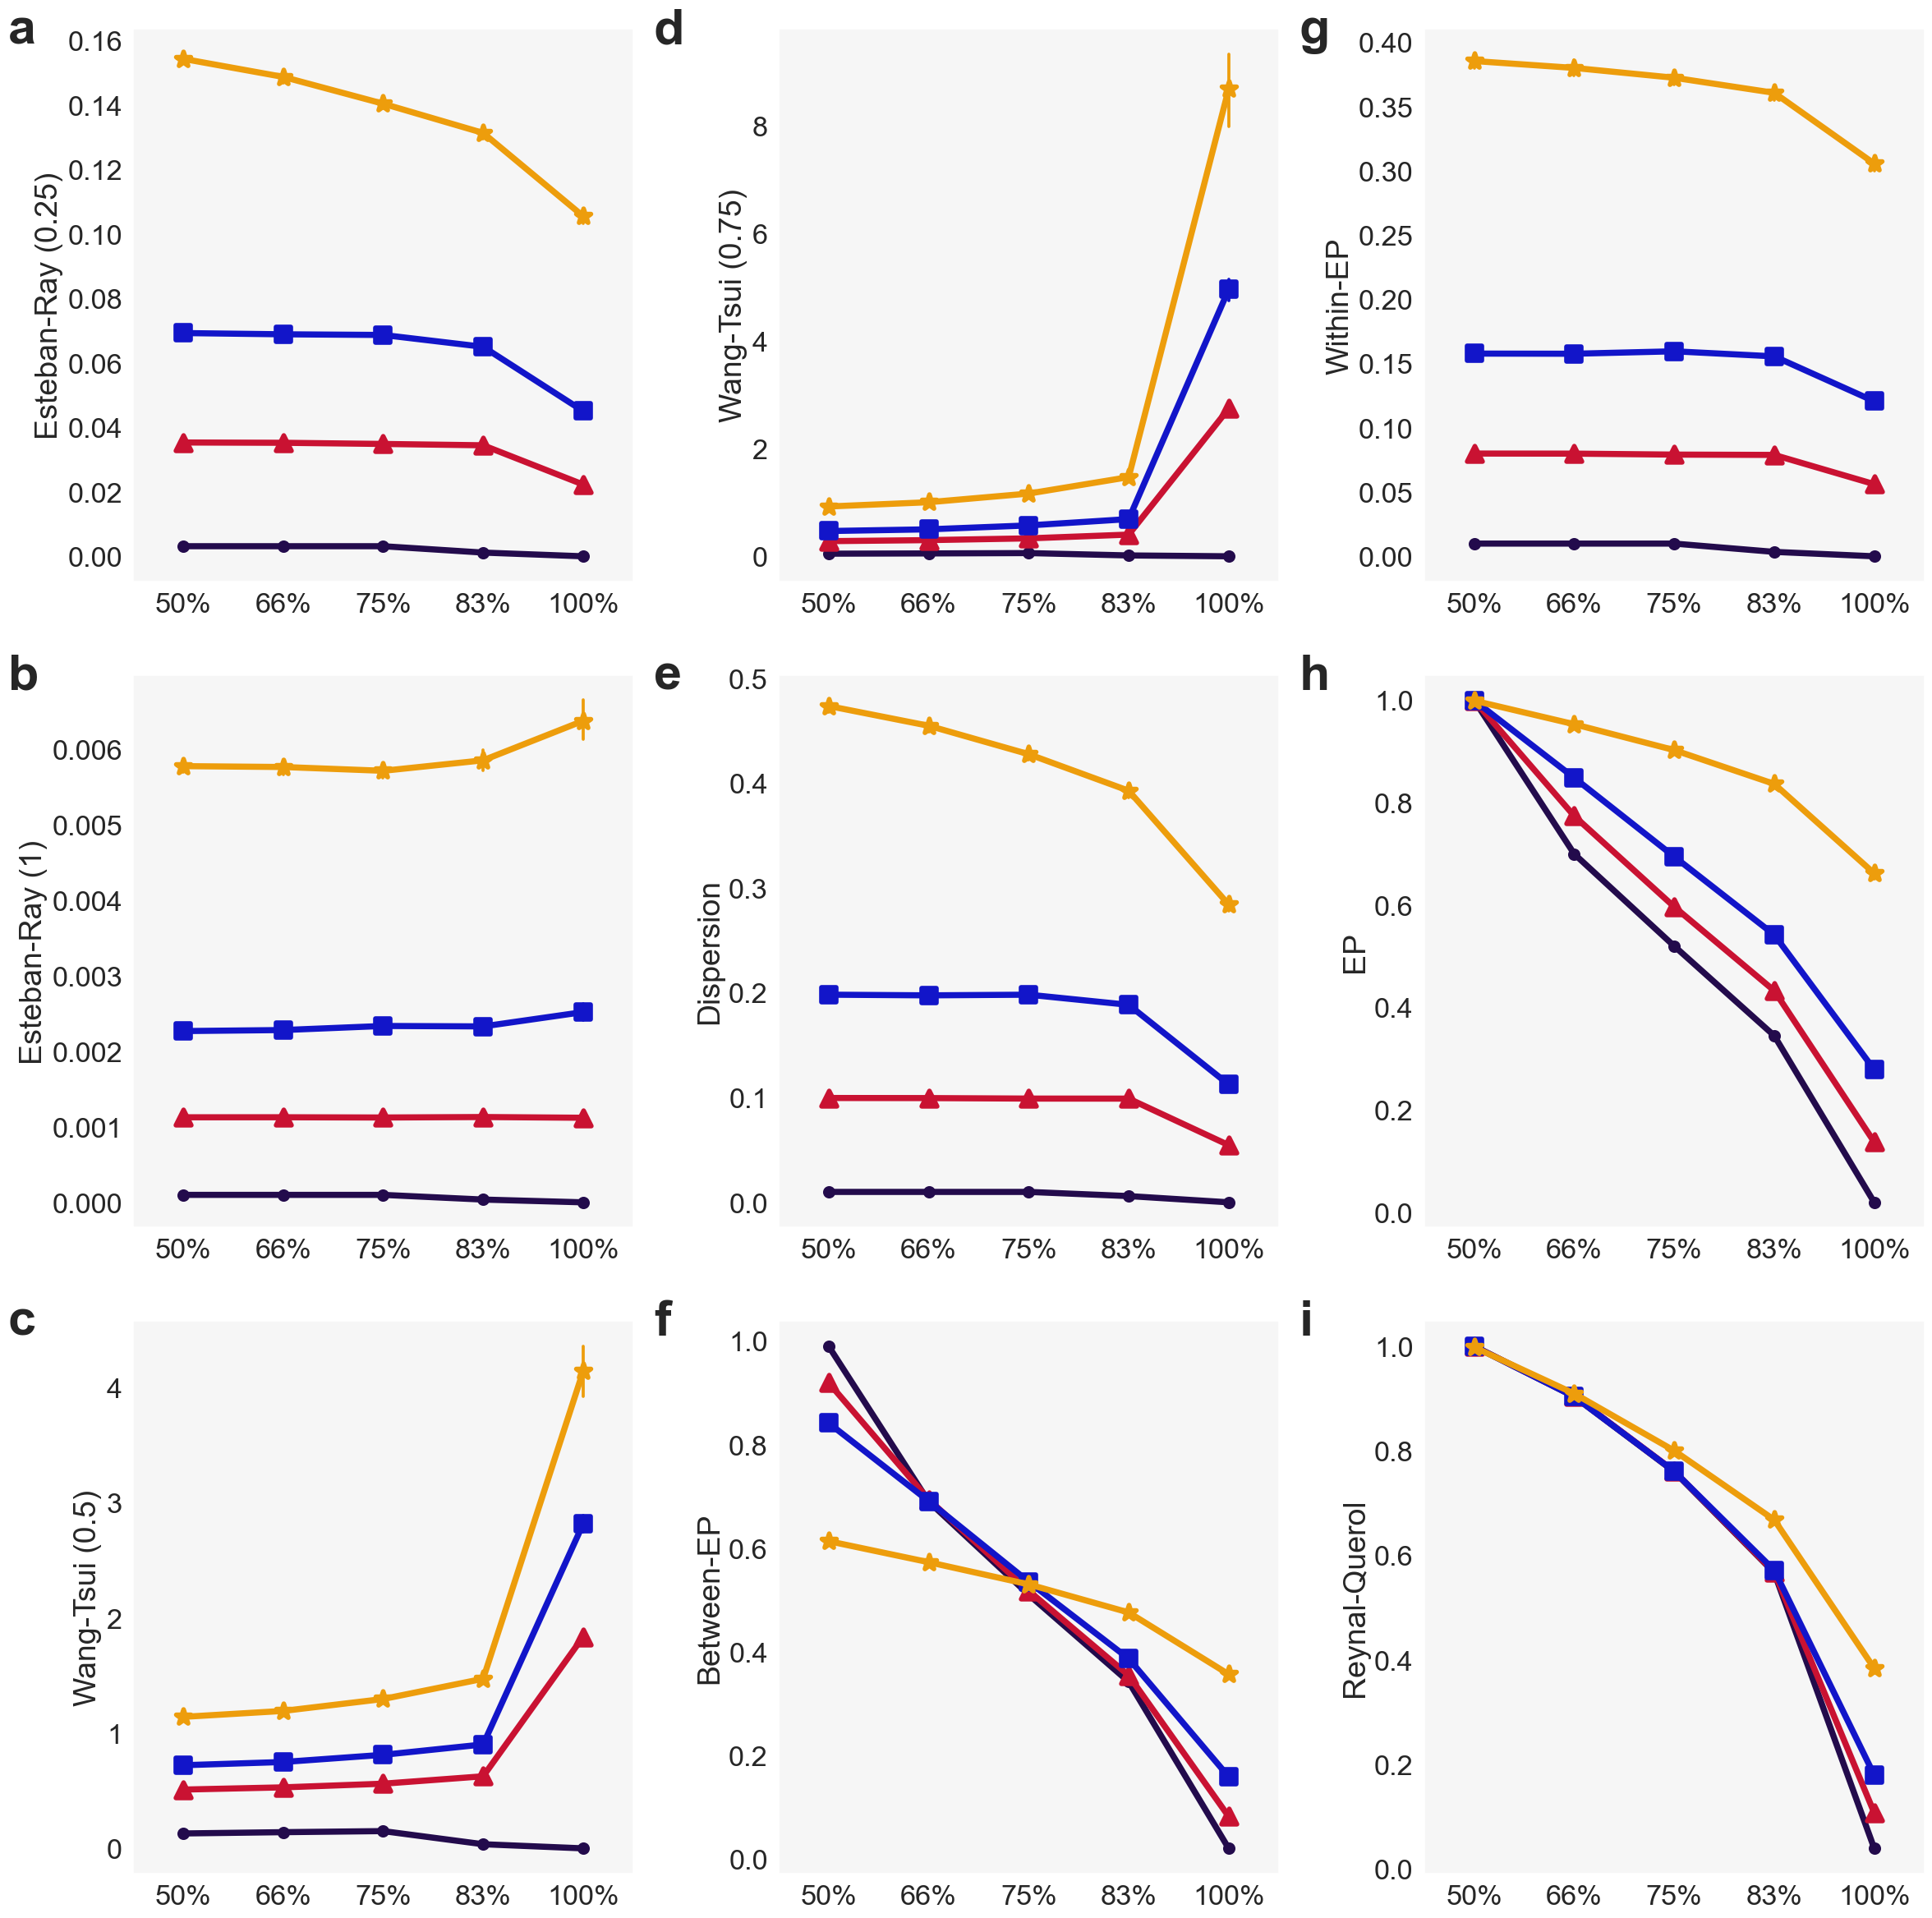

In [75]:
sns.set(font_scale=2.25, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(24, 24))
labels = list("abcdefghijklm")

i = 0
for idx, item in enumerate([
    ("Esteban-Ray (0.25)", df_ER),
    ("Esteban-Ray (1)", df_ER2),
    ("Wang-Tsui (0.5)", df_TW),
    ("Wang-Tsui (0.75)", df_TW2),
    ("Dispersion", df_DP),
    ("Between-EP", df_BW),
    ("Within-EP", df_WT),
    ("EP", df_EP),
    ("Reynal-Querol", df_RQ)
]):
    label, df_item = item
    df_item = df_item.copy()
    df_item["mu"] = df_item["mu"].apply(lambda x: f"{int(x * 100)}%")
    ax = axs[idx%3, int(idx/3)]#
    sns.pointplot(
        x="mu", hue="sigma", 
        scale=2, y="value", 
        markers=[".", "^", "s", "*"], 
        palette=["#230B4C", "#C91232", "#1215C9", "#ED9D0C"], 
        data=df_item, ax=ax)
    # ax.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=0))
    ax.set_ylabel(label)
    ax.set_xlabel("")
    ax.text(-0.25, 0.975, labels[i], fontsize=44, transform=ax.transAxes, fontweight=700)
    i += 1

    leg = ax.legend()
    leg.remove()

# sns.despine(offset=10, trim=True)
fig.savefig(f"Figures_Appendix/Comparison_Polarization_Simulations.pdf")

fig.tight_layout()


In [66]:
from scipy.stats import pearsonr

polarization = [
    ("Esteban-Ray (0.25)", df_ER),
    ("Esteban-Ray (1)", df_ER2),
    ("Wang-Tsui (0.5)", df_TW),
    ("Wang-Tsui (0.75)", df_TW2),
    ("Dispersion", df_DP),
    ("Between-EP", df_BW),
    ("Within-EP", df_WT),
    ("EP", df_EP),
    ("Reynal-Querol", df_RQ)
]

output = []
df_output = []
for mu in df_ER.mu.unique():
    for sigma in df_ER.sigma.unique():
        for xx in polarization:
            x1 = xx[1]
            x1 = x1[(x1["mu"] == mu) & (x1["sigma"] == sigma)]
            for yy in polarization:
                y1 = yy[1]
                y1 = y1[(y1["mu"] == mu) & (y1["sigma"] == sigma)]
                if xx[0] != yy[0]:
                    value, pvalue = pearsonr(x1["value"], y1["value"])
                    output.append({
                        "value": value,
                        "pvalue": pvalue,
                        "xx": xx[0],
                        "yy": yy[0],
                        "mu": mu,
                        "sigma": sigma
                    })

        tmp = pd.DataFrame(output)
        # tmp["mu"] = mu
        df_output.append(tmp)

data = pd.concat(df_output).drop_duplicates()
data

,value,pvalue,xx,yy,mu,sigma
0,1.000000,7.905050e-323,Esteban-Ray (0.25),Esteban-Ray (1),0.5,0.0025
1,0.753786,1.425275e-19,Esteban-Ray (0.25),Wang-Tsui (0.5),0.5,0.0025
2,0.880601,1.488351e-33,Esteban-Ray (0.25),Wang-Tsui (0.75),0.5,0.0025
3,0.999964,4.366798e-205,Esteban-Ray (0.25),Dispersion,0.5,0.0025
4,0.265141,7.676577e-03,Esteban-Ray (0.25),Between-EP,0.5,0.0025
...,...,...,...,...,...,...
1435,-0.495368,1.607785e-07,Reynal-Querol,Wang-Tsui (0.75),1.0,0.2500
1436,0.825332,4.578685e-26,Reynal-Querol,Dispersion,1.0,0.2500
1437,0.815454,5.261134e-25,Reynal-Querol,Between-EP,1.0,0.2500
1438,0.568649,6.748152e-10,Reynal-Querol,Within-EP,1.0,0.2500


In [32]:
df_WT[(df_WT["mu"] == 0.5) & (df_WT["sigma"] == 0.0025)].shape

(100, 5)

Text(0, 0.5, '')

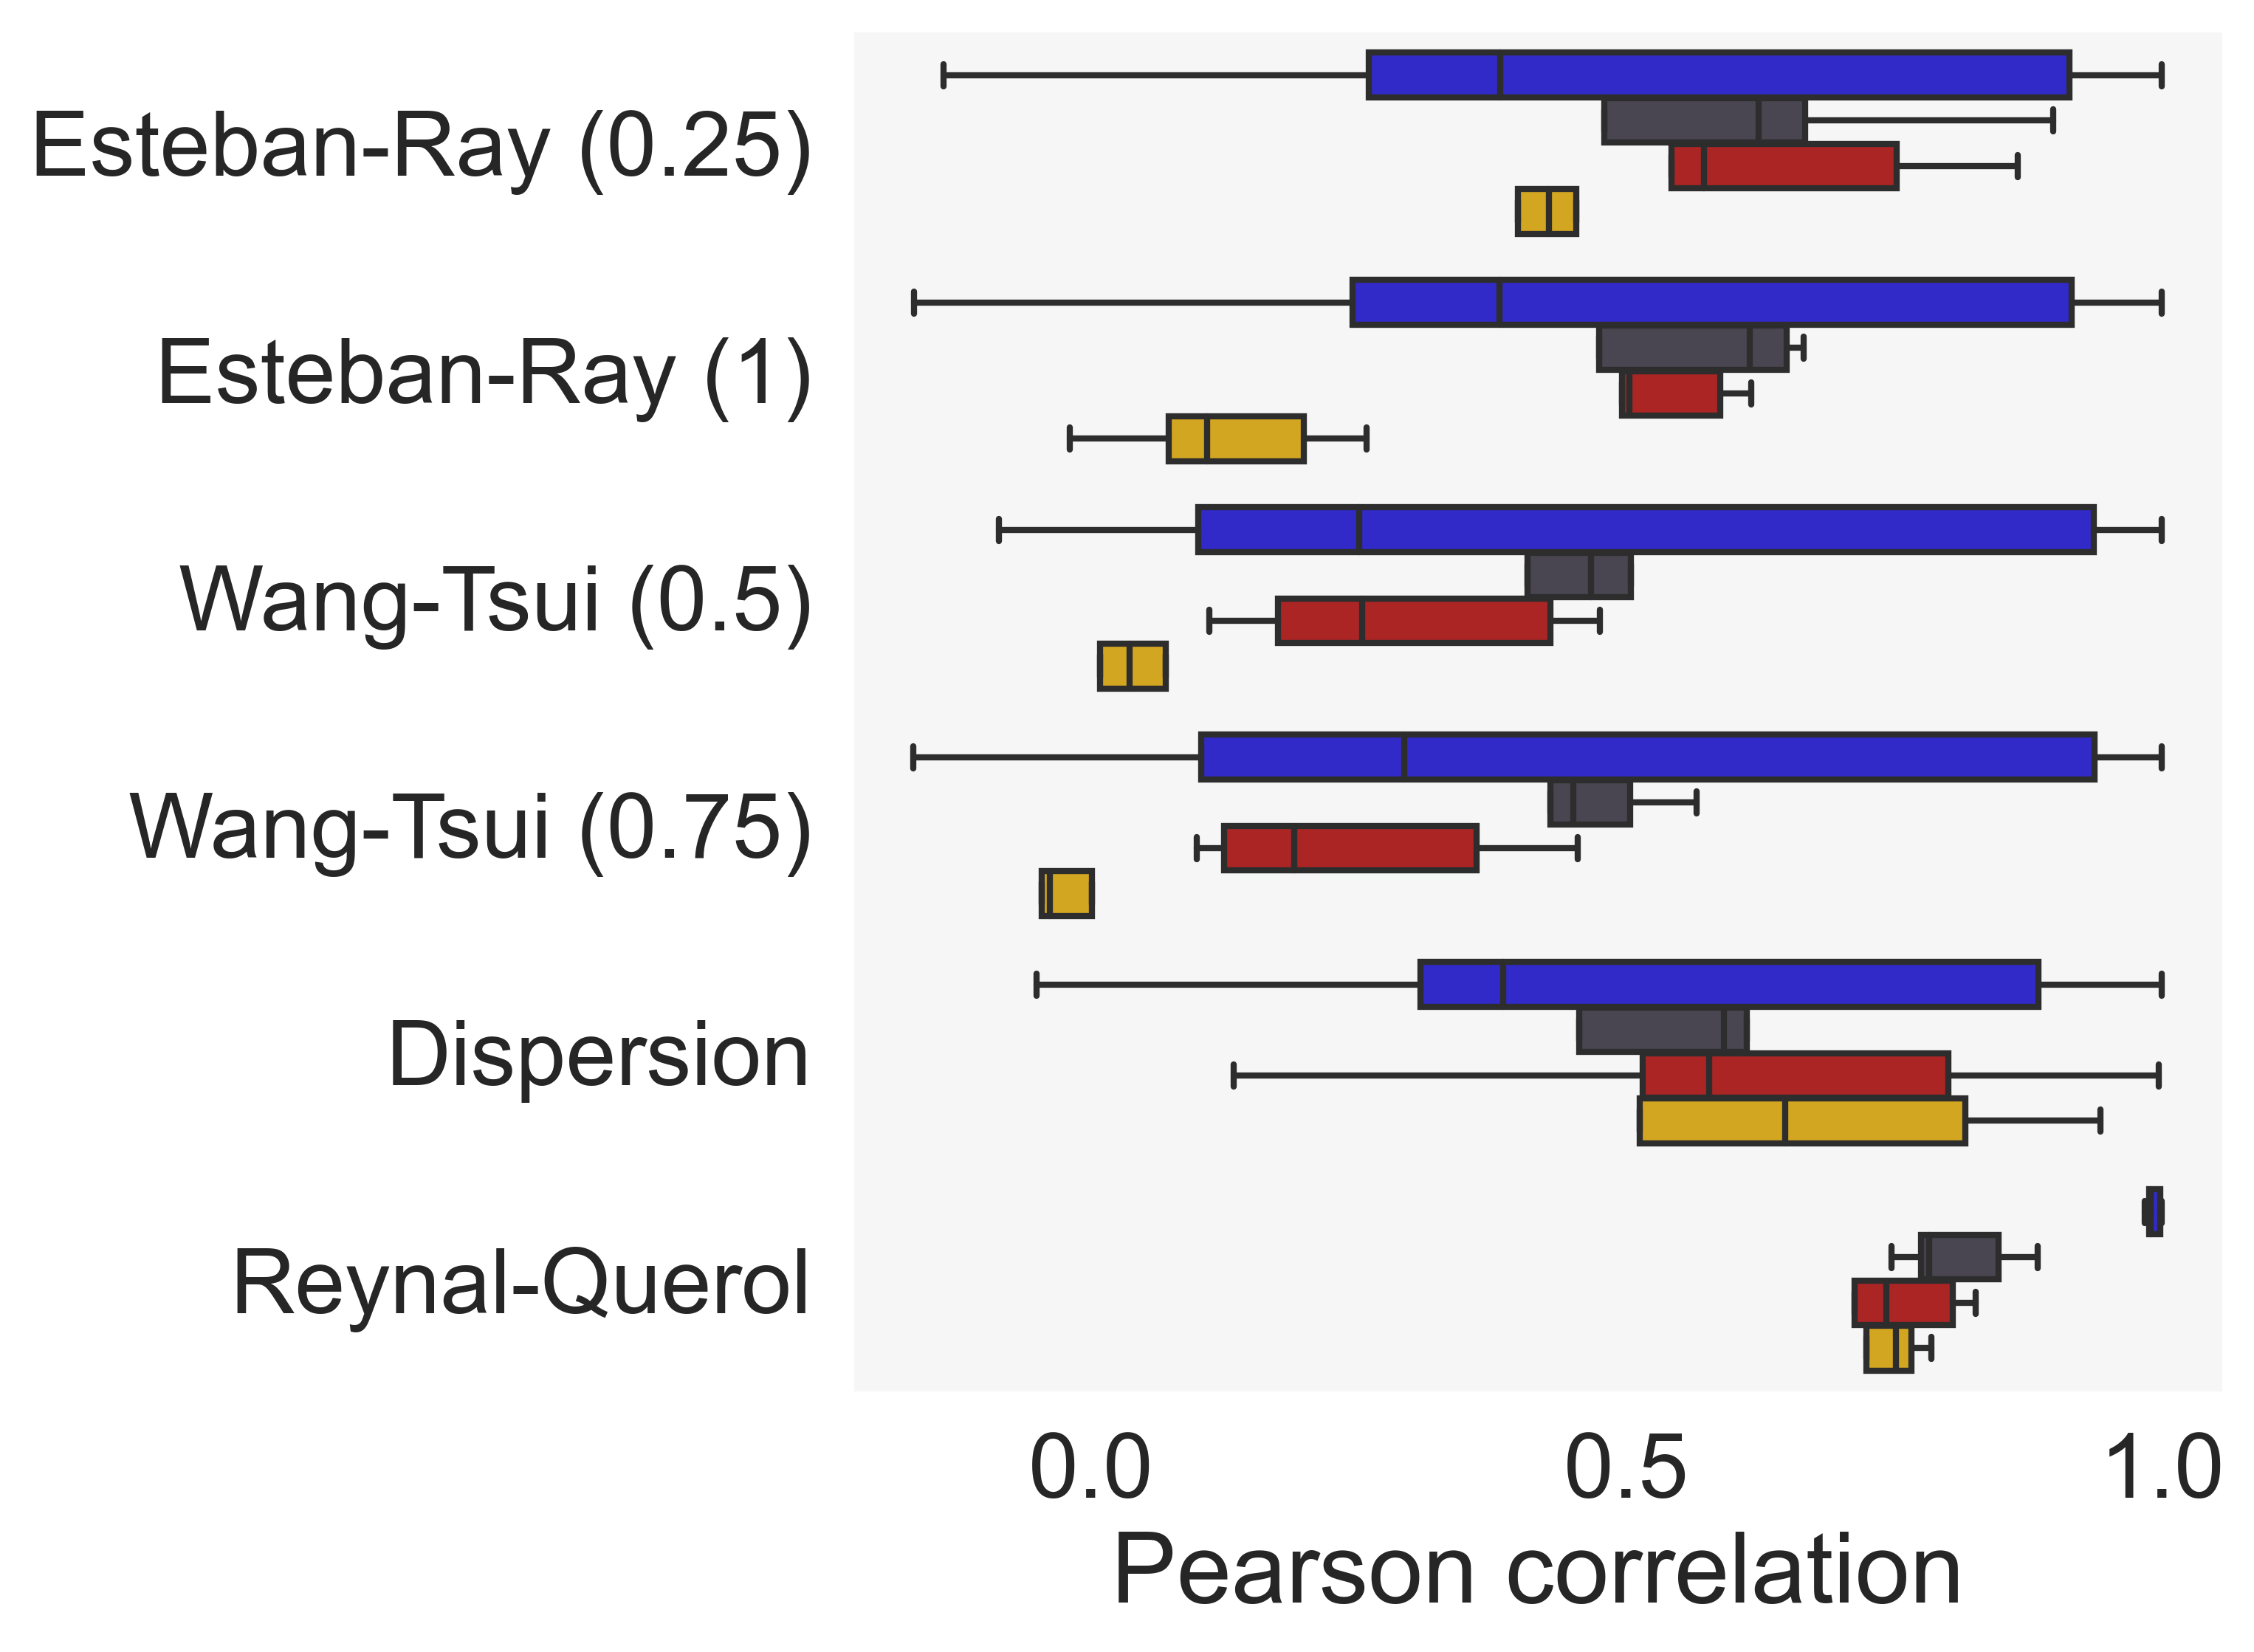

In [69]:
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

fig, ax = plt.subplots(figsize=(6, 6), dpi=400)

ax = sns.boxplot(
    y="yy",
    x="value",
    hue="sigma",
    showfliers=False,
    palette=["#1910E2", "#4A4453", "#C10F0F", "#F0B505", "#007A1A"],
    data=data[(data["xx"] == "EP") & ~(data["yy"].isin(["EP", "Between-EP", "Within-EP"]))]
)

# plt.xticks(rotation=90)
leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
leg.remove()
ax.set_xlabel("Pearson correlation")
ax.set_ylabel("")

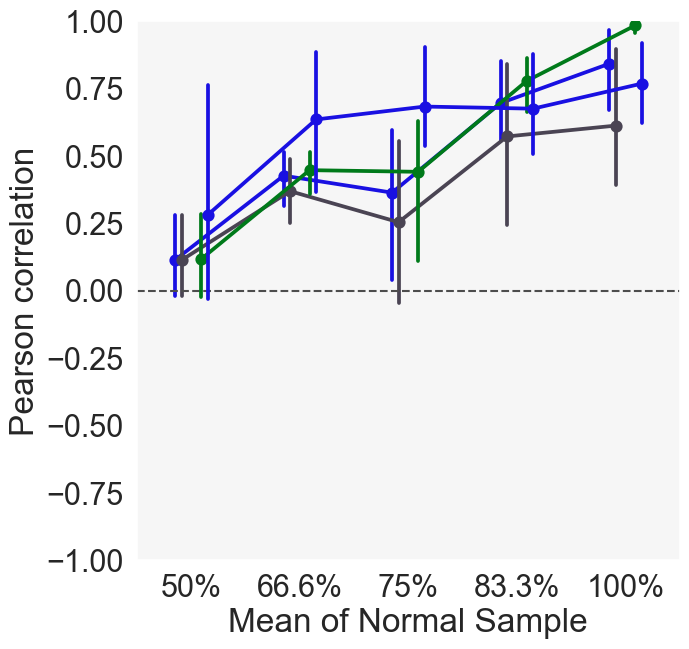

In [34]:
sns.set(font_scale=2, rc={"axes.facecolor": "#f6f6f6", "axes.grid" : False})

order = ["Esteban-Ray (0.25)", "Esteban-Ray (1)", "Tsui-Wang (0.5)", "Tsui-Wang (0.75)", "Dispersion", "Reynal-Querol"]

fig, ax = plt.subplots(figsize=(7, 7))
sns.pointplot(x="mu", y="value", hue="yy", dodge=0.3, hue_order=order,
    palette=["#1910E2", "#4A4453", "#C10F0F", "#F0B505", "#007A1A"],
    data=data[(data["xx"] == "EP") & ~(data["yy"].isin(["EP", "Between-EP", "Within-EP"]))])
ax.axhline(y=0, ls="--", c=".3")
ax.set_ylabel("Pearson correlation")
ax.set_xlabel("Mean of Normal Sample")
ax.set_xticklabels(["50%", "66.6%", "75%", "83.3%", "100%"])
ax.set_ylim(-1, 1)
lgd = plt.legend(bbox_to_anchor=(1.01, 1), loc='upper left')
lgd.remove()